In [356]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

In [358]:
import requests

# URLs of the files
train_data_url = 'https://www.raphaelcousin.com/modules/module5/exercise/module5_exercise_train.csv'
test_data_url = 'https://www.raphaelcousin.com/modules/module5/exercise/module5_exercise_test.csv'

# Function to download a file
def download_file(url, file_name):
    response = requests.get(url)
    response.raise_for_status()  # Ensure we notice bad responses
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print(f'Downloaded {file_name} from {url}')

# Downloading the files
download_file(train_data_url, 'module5_exercise_train.csv')
download_file(test_data_url, 'module5_exercise_test.csv')

Downloaded module5_exercise_train.csv from https://www.raphaelcousin.com/modules/module5/exercise/module5_exercise_train.csv
Downloaded module5_exercise_test.csv from https://www.raphaelcousin.com/modules/module5/exercise/module5_exercise_test.csv


In [360]:
df_train =  pd.read_csv("module5_exercise_train.csv", sep=",")
df_test =  pd.read_csv("module5_exercise_test.csv", sep=",")

In [362]:
df_train.info()
df_train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1909 entries, 0 to 1908
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       1909 non-null   object 
 1   weather_condition          1885 non-null   object 
 2   humidity                   1813 non-null   float64
 3   wind_speed                 1819 non-null   object 
 4   oil_brent_price_indicator  1909 non-null   object 
 5   temperature_station1       1624 non-null   float64
 6   temperature_station2       1634 non-null   float64
 7   temperature_station3       1620 non-null   float64
 8   temperature_station4       1632 non-null   float64
 9   temperature_station5       1630 non-null   float64
 10  temperature_station6       1636 non-null   float64
 11  temperature_station7       1601 non-null   float64
 12  temperature_station8       1627 non-null   float64
 13  temperature_station9       1621 non-null   float

,date,weather_condition,humidity,wind_speed,oil_brent_price_indicator,temperature_station1,temperature_station2,temperature_station3,temperature_station4,temperature_station5,temperature_station6,temperature_station7,temperature_station8,temperature_station9,temperature_station10,electricity_demand
0,2015-01-08,Cloudy,69.304377,27.74 km/h,Moderate,0.369411,NaN,0.159977,0.118224,-0.444455,0.313675,0.106192,0.369430,1.279470,-0.384661,273.511353
1,2015-01-09,Sunny,55.955975,21.78 km/h,Moderate,2.009903,NaN,1.617242,NaN,2.160063,2.515627,1.867474,1.953165,1.878233,1.582365,258.827085
2,2015-01-10,Rainy,62.701614,6.83 m/s,Moderate,-2.603544,-2.422001,-3.685819,-2.392354,-1.936704,-2.950332,-3.074828,-2.698650,-2.354860,-2.770883,302.535033
3,2015-01-11,Snowy,60.375001,5.79 m/s,Moderate,-3.789836,-3.974054,-3.217545,-4.397143,-3.375188,-3.650454,-5.004991,-3.233724,-4.227899,NaN,296.270989
4,2015-01-12,Snowy,NaN,25.14 km/h,High,-2.405522,-2.161129,-2.880773,-2.587199,NaN,NaN,NaN,NaN,-2.790422,-2.033098,323.498090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1904,2019-12-28,Sunny,67.220123,18.33 km/h,High,3.209205,2.508606,2.195577,NaN,NaN,3.236547,3.181473,3.094390,NaN,3.475638,254.061886
1905,2019-12-29,Rainy,68.085227,7.24 m/s,Moderate,3.688132,3.919479,NaN,4.071717,4.365347,3.580358,3.404292,4.173461,3.755625,4.070333,266.231273
1906,2019-12-29,Rainy,68.085227,7.24 m/s,Moderate,3.688132,3.919479,NaN,4.071717,4.365347,3.580358,3.404292,4.173461,3.755625,4.070333,266.231273
1907,2019-12-30,Cloudy,65.877214,7.67 m/s,Moderate,NaN,0.700484,NaN,-0.407440,-0.580917,-0.444730,0.034229,0.021199,-0.864657,NaN,296.431897


## Inconsistencies

In [364]:
import re
# Detect date format issues
print(df_train['date'].apply(lambda x: not re.match(r'\d{4}-\d{2}-\d{2}', x)).sum())

0


In [366]:
# km/h pour toutes les lignes
df_train['wind_speed_value'] = df_train['wind_speed'].str.extract(r'(\d+\.?\d*)').astype(float)
df_train['wind_speed_unit'] = df_train['wind_speed'].str.extract(r'([a-zA-Z/]+)')

# 1 m/s = 3.6km/h
df_train.loc[df_train['wind_speed_unit'] == 'm/s', 'wind_speed_value'] *= 3.6

df_train['wind_speed'] = df_train['wind_speed_value']

df_train = df_train.drop(columns=['wind_speed_value', 'wind_speed_unit'])


In [368]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1909 entries, 0 to 1908
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       1909 non-null   object 
 1   weather_condition          1885 non-null   object 
 2   humidity                   1813 non-null   float64
 3   wind_speed                 1819 non-null   float64
 4   oil_brent_price_indicator  1909 non-null   object 
 5   temperature_station1       1624 non-null   float64
 6   temperature_station2       1634 non-null   float64
 7   temperature_station3       1620 non-null   float64
 8   temperature_station4       1632 non-null   float64
 9   temperature_station5       1630 non-null   float64
 10  temperature_station6       1636 non-null   float64
 11  temperature_station7       1601 non-null   float64
 12  temperature_station8       1627 non-null   float64
 13  temperature_station9       1621 non-null   float

## Duplicates

In [370]:
print("Before removing exact duplicates:")
print(df_train.shape)
# Identify duplicates based on all columns or specific columns
df_train.loc[:, 'is_duplicate'] = df_train.duplicated(keep=False)

# Supprimer les duplicates
df_train = df_train.drop_duplicates()

df_train.drop(columns=['is_duplicate'], inplace=True)
print("After removing exact duplicates:")
print(df_train.shape)

Before removing exact duplicates:
(1909, 16)
After removing exact duplicates:
(1819, 16)


## Missing Value

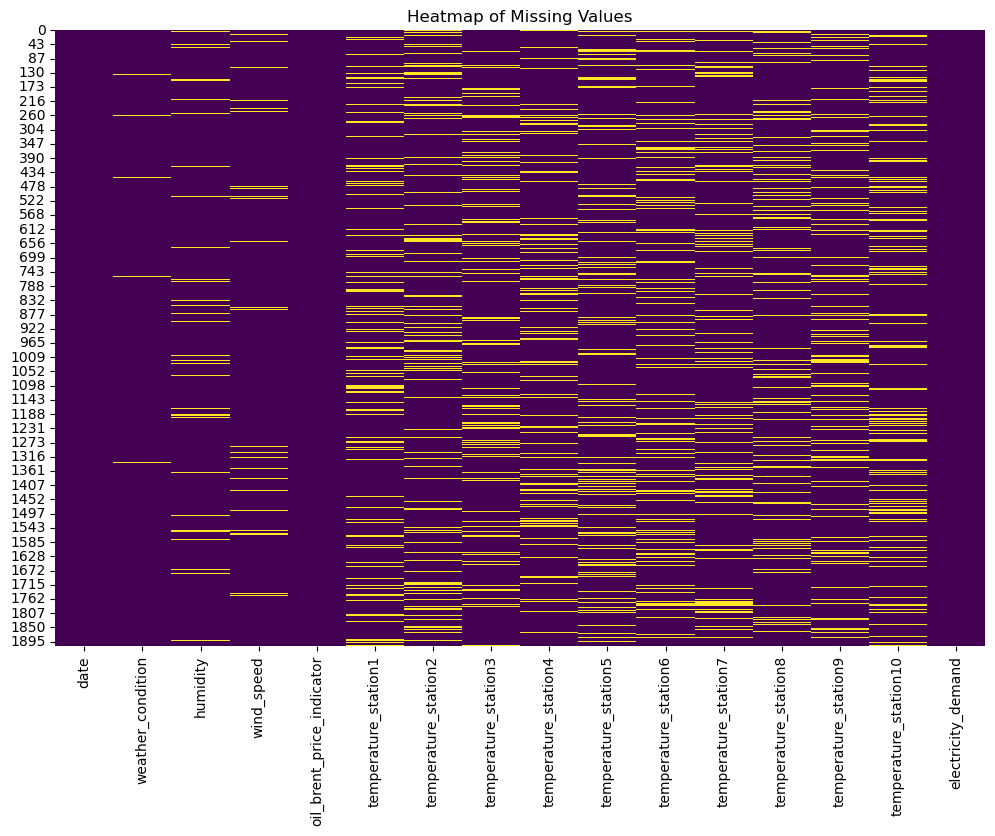

In [372]:
# Heatmap to show where missing values occur
plt.figure(figsize=(12, 8))
sns.heatmap(df_train.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values')
plt.show()

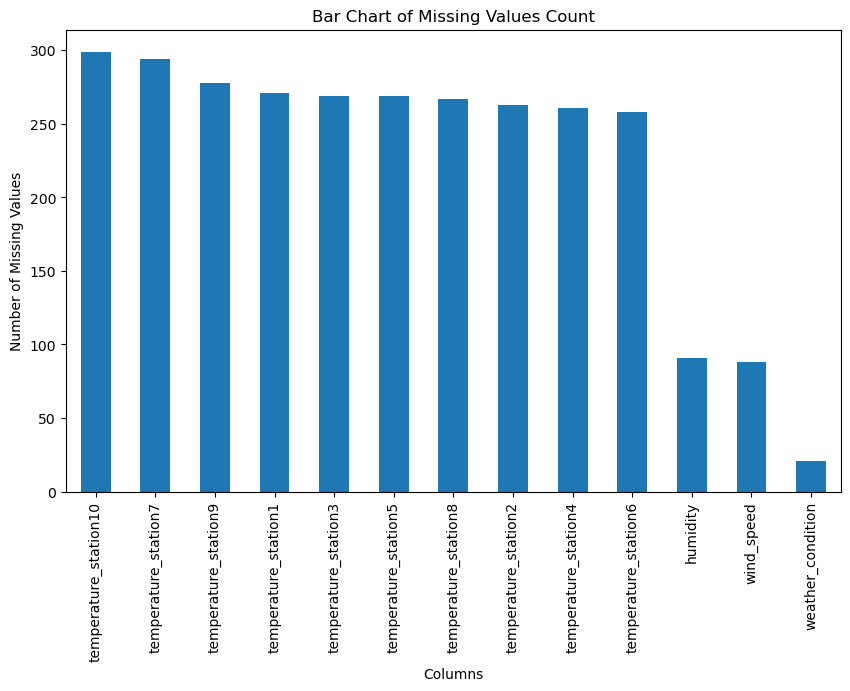

Percentage of missing values per column:
date                          0.00
weather_condition             1.15
humidity                      5.00
wind_speed                    4.84
oil_brent_price_indicator     0.00
temperature_station1         14.90
temperature_station2         14.46
temperature_station3         14.79
temperature_station4         14.35
temperature_station5         14.79
temperature_station6         14.18
temperature_station7         16.16
temperature_station8         14.68
temperature_station9         15.28
temperature_station10        16.44
electricity_demand            0.00
dtype: float64


In [374]:
# Bar chart for missing values count
missing_counts = df_train.isnull().sum().sort_values(ascending=False)
missing_counts = missing_counts[missing_counts > 0]
plt.figure(figsize=(10, 6))
missing_counts.plot(kind='bar')
plt.title('Bar Chart of Missing Values Count')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.show()

print("Percentage of missing values per column:")
print((df_train.isnull().sum() / len(df_train) * 100).round(2))

In [376]:
# Mode imputation for categorical column
df_train['weather_condition'] = df_train['weather_condition'].fillna(df_train['weather_condition'].mode()[0])

Average Results:

Mean Imputation:
  Train_mse: 14761895.5489 ± 18260904.1629
  Test_mse: 33627876.0180 ± 67062286.0681
  Train_mae: 209.2187 ± 224.9765
  Test_mae: 317.9621 ± 306.7408

Median Imputation:
  Train_mse: 14765102.4178 ± 18264677.1063
  Test_mse: 33621970.3024 ± 67057348.2505
  Train_mae: 207.5963 ± 223.1419
  Test_mae: 316.4680 ± 306.6411

Zero Imputation:
  Train_mse: 14787464.6459 ± 18293108.2688
  Test_mse: 33073414.7787 ± 66017592.0851
  Train_mae: 187.7642 ± 196.6812
  Test_mae: 284.5117 ± 280.5212

KNN Imputation:
  Train_mse: 14698734.7091 ± 18179703.6106
  Test_mse: 33928476.1488 ± 67502630.2177
  Train_mae: 261.5343 ± 292.1845
  Test_mae: 374.0997 ± 322.0832

Iterative Imputation:
  Train_mse: 14694337.4013 ± 18175927.3958
  Test_mse: 35141144.2431 ± 66765156.6261
  Train_mae: 267.4704 ± 297.9891
  Test_mae: 403.1684 ± 337.7070

Backward Fill Imputation:
  Train_mse: 14715268.6924 ± 18202049.5129
  Test_mse: 34608478.8588 ± 68899832.7863
  Train_mae: 242.7027 ± 2

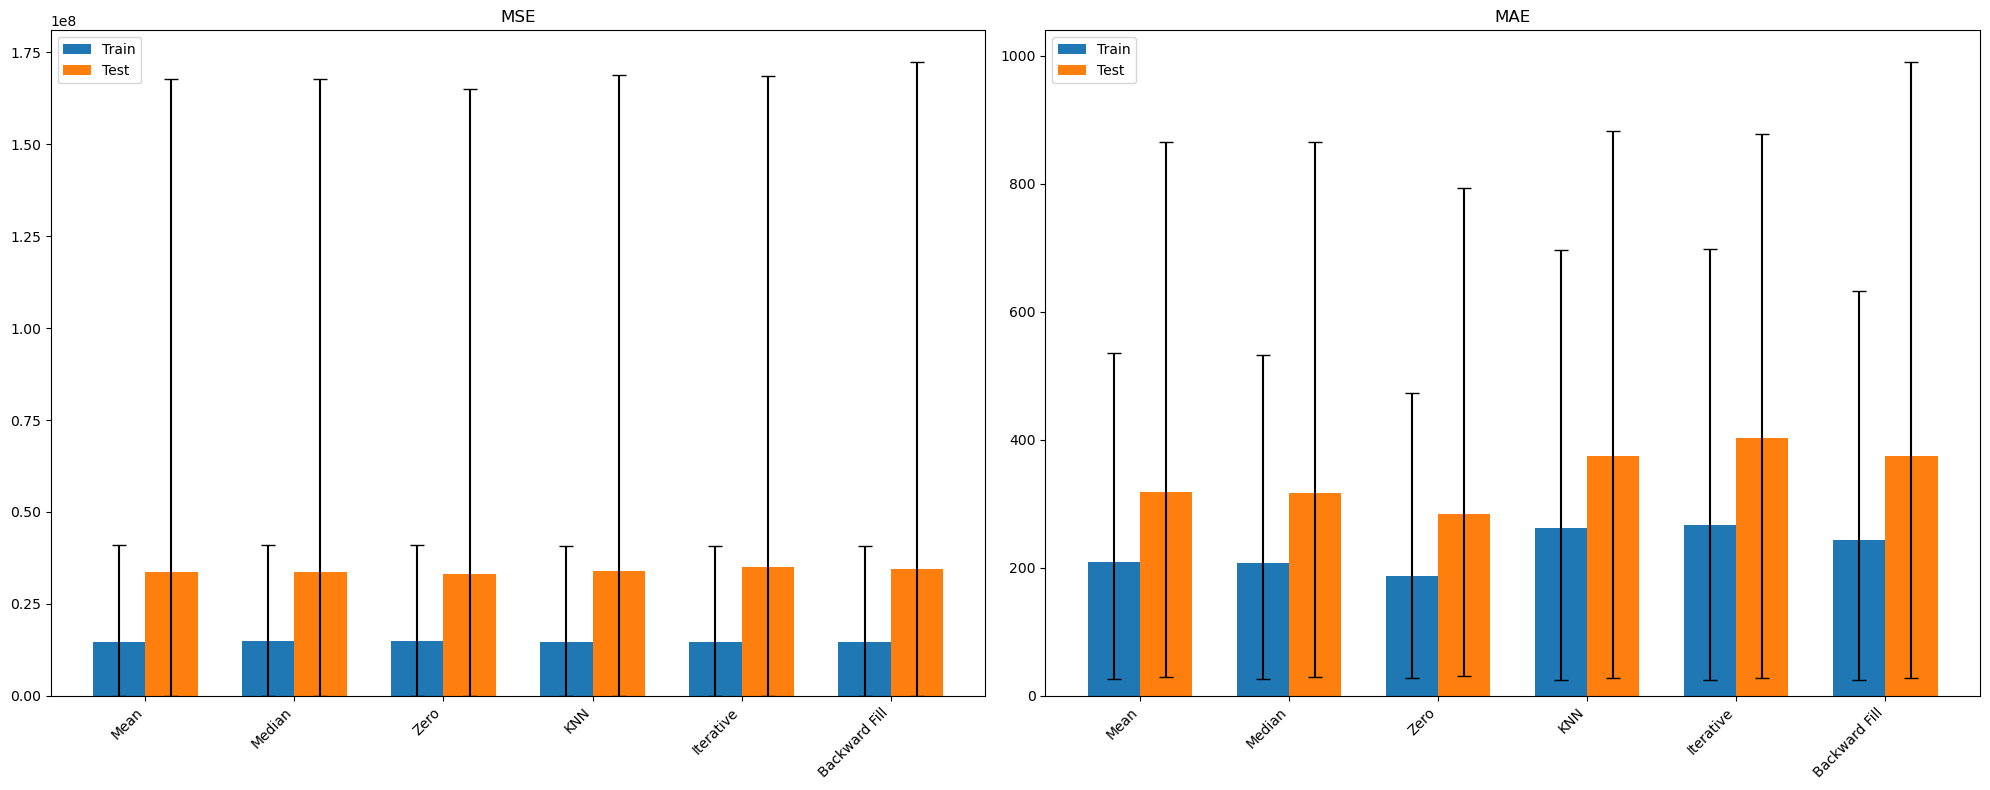

In [378]:
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.metrics import mean_squared_error, mean_absolute_error

def split_data(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    return tscv.split(X)

def impute_data(imputer, X_train, X_test, add_indicator=False):
    if add_indicator:
        imputer = SimpleImputer(add_indicator=True, strategy='mean')
    
    X_train_imputed = pd.DataFrame(
        imputer.fit_transform(X_train),
        columns=imputer.get_feature_names_out(X_train.columns),
        index=X_train.index
    )
    X_test_imputed = pd.DataFrame(
        imputer.transform(X_test),
        columns=imputer.get_feature_names_out(X_test.columns),
        index=X_test.index
    )
    return X_train_imputed, X_test_imputed

def bfill_impute(X_train, X_test):
    X_train_imputed = X_train.bfill().fillna(X_train.mean())  
    X_test_imputed = X_test.bfill().fillna(X_test.mean())  
    return X_train_imputed, X_test_imputed



def evaluate_model(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    return {
        'train_mse': mean_squared_error(y_train, y_train_pred),
        'test_mse': mean_squared_error(y_test, y_test_pred),
        'train_mae': mean_absolute_error(y_train, y_train_pred),
        'test_mae': mean_absolute_error(y_test, y_test_pred),
    }

def plot_results(results):
    metrics = ['mse', 'mae']
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    for i, metric in enumerate(metrics):
        train_values = [np.mean(results[strategy][f'train_{metric}']) for strategy in results]
        test_values = [np.mean(results[strategy][f'test_{metric}']) for strategy in results]
        train_min = [np.min(results[strategy][f'train_{metric}']) for strategy in results]
        train_max = [np.max(results[strategy][f'train_{metric}']) for strategy in results]
        test_min = [np.min(results[strategy][f'test_{metric}']) for strategy in results]
        test_max = [np.max(results[strategy][f'test_{metric}']) for strategy in results]
        
        x = np.arange(len(results))
        width = 0.35
        
        axes[i].bar(x - width/2, train_values, width, 
                    yerr=[np.array(train_values) - np.array(train_min), 
                          np.array(train_max) - np.array(train_values)], 
                    label='Train', capsize=5)
        axes[i].bar(x + width/2, test_values, width, 
                    yerr=[np.array(test_values) - np.array(test_min), 
                          np.array(test_max) - np.array(test_values)], 
                    label='Test', capsize=5)
        
        axes[i].set_title(f'{metric.upper()}')
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(list(results.keys()), rotation=45, ha='right')
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

# Assuming df is your dataset and 'ActivePower' is your target variable
X = df_train.drop(['electricity_demand','weather_condition','date','oil_brent_price_indicator'], axis=1)
y = df_train['electricity_demand']

# Define imputation strategies
imputers = {
    "Mean": SimpleImputer(strategy='mean'),
    "Median": SimpleImputer(strategy='median'),
    "Zero": SimpleImputer(strategy='constant', fill_value=0),
    "KNN": KNNImputer(n_neighbors=5),
    "Iterative": IterativeImputer(estimator=BayesianRidge(), random_state=0, max_iter=300),
    "Backward Fill": "bfill"
}

# Initialize results dictionary
results = {name: {'train_mse': [], 'test_mse': [], 'train_mae': [], 'test_mae': []} for name in imputers}

# Perform cross-validation
tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    for name, imputer in imputers.items():
        
        # Impute data
        if name == "Backward Fill":
            X_train_imputed, X_test_imputed = bfill_impute(X_train, X_test)
        else:
            X_train_imputed, X_test_imputed = impute_data(imputer, X_train, X_test)
        #ffill ne marche pas car il manque les donnees en deux premieres lignes pour la colonne temperature_station2
        #print(X_train[['temperature_station2']].head(10))
        # Train and evaluate model
        model = LinearRegression()
        model.fit(X_train_imputed, y_train)
        fold_results = evaluate_model(model, X_train_imputed, X_test_imputed, y_train, y_test)
        
        for metric in ['train_mse', 'test_mse', 'train_mae', 'test_mae']:
            results[name][metric].append(fold_results[metric])
        # print(f"Evaluating {name} imputation:")
        # print(f"  Train MSE: {fold_results['train_mse']:.4f}")
        # print(f"  Test MSE: {fold_results['test_mse']:.4f}")
        # print(f"  Train MAE: {fold_results['train_mae']:.4f}")
        # print(f"  Test MAE: {fold_results['test_mae']:.4f}")
        # print()

# Calculate and print average results
print("Average Results:")
for name in imputers:
    print(f"\n{name} Imputation:")
    for metric in ['train_mse', 'test_mse', 'train_mae', 'test_mae']:
        mean_value = np.mean(results[name][metric])
        std_value = np.std(results[name][metric])
        print(f"  {metric.capitalize()}: {mean_value:.4f} ± {std_value:.4f}")

# Plot results
plot_results(results)

## Je choisis de remplir avec la moyenne

In [380]:
numeric_cols = df_train.select_dtypes(include=['number']).columns

imputer = SimpleImputer(strategy='mean')

df_train[numeric_cols] = imputer.fit_transform(df_train[numeric_cols])

print(df_train.head())

         date weather_condition    humidity  wind_speed  \
0  2015-01-08            Cloudy   69.304377      27.740   
1  2015-01-09             Sunny   55.955975      21.780   
2  2015-01-10             Rainy   62.701614      24.588   
3  2015-01-11             Snowy   60.375001      20.844   
4  2015-01-12             Snowy  118.713271      25.140   

  oil_brent_price_indicator  temperature_station1  temperature_station2  \
0                  Moderate              0.369411             13.044193   
1                  Moderate              2.009903             13.044193   
2                  Moderate             -2.603544             -2.422001   
3                  Moderate             -3.789836             -3.974054   
4                      High             -2.405522             -2.161129   

   temperature_station3  temperature_station4  temperature_station5  \
0              0.159977              0.118224             -0.444455   
1              1.617242             13.279377       

## Categorical values

In [382]:
unique_values1 = df_train['weather_condition'].unique()
unique_values2 = df_train['oil_brent_price_indicator'].unique()
print(unique_values1)
print(unique_values2)

['Cloudy' 'Sunny' 'Rainy' 'Snowy']
['Moderate' 'High' 'Low' 'Very Low' 'Very High']


In [384]:
#One hot encoding pour weather_condition
df_train = pd.get_dummies(df_train, columns=['weather_condition'])
print("One-hot encoded DataFrame:")
print(df_train)

One-hot encoded DataFrame:
            date    humidity  wind_speed oil_brent_price_indicator  \
0     2015-01-08   69.304377      27.740                  Moderate   
1     2015-01-09   55.955975      21.780                  Moderate   
2     2015-01-10   62.701614      24.588                  Moderate   
3     2015-01-11   60.375001      20.844                  Moderate   
4     2015-01-12  118.713271      25.140                      High   
...          ...         ...         ...                       ...   
1903  2019-12-27   71.521673      22.780                  Moderate   
1904  2019-12-28   67.220123      18.330                      High   
1905  2019-12-29   68.085227      26.064                  Moderate   
1907  2019-12-30   65.877214      27.612                  Moderate   
1908  2019-12-31   62.344026      30.990                       Low   

      temperature_station1  temperature_station2  temperature_station3  \
0                 0.369411             13.044193          

In [386]:
price_mapping = {
    'Very High': 5,
    'High': 4,
    'Moderate': 3,
    'Low': 2,
    'Very Low': 1
}
df_train['oil_price_label'] = df_train['oil_brent_price_indicator'].map(price_mapping)
df_train.drop('oil_brent_price_indicator',axis=1,inplace=True )
print("Label encoded DataFrame:")
print(df_train)

print("Encoding mappings:")
print("Price mapping:", price_mapping)


Label encoded DataFrame:
            date    humidity  wind_speed  temperature_station1  \
0     2015-01-08   69.304377      27.740              0.369411   
1     2015-01-09   55.955975      21.780              2.009903   
2     2015-01-10   62.701614      24.588             -2.603544   
3     2015-01-11   60.375001      20.844             -3.789836   
4     2015-01-12  118.713271      25.140             -2.405522   
...          ...         ...         ...                   ...   
1903  2019-12-27   71.521673      22.780             -1.674798   
1904  2019-12-28   67.220123      18.330              3.209205   
1905  2019-12-29   68.085227      26.064              3.688132   
1907  2019-12-30   65.877214      27.612             13.364007   
1908  2019-12-31   62.344026      30.990              0.685487   

      temperature_station2  temperature_station3  temperature_station4  \
0                13.044193              0.159977              0.118224   
1                13.044193        

# Ourliers

number of outliers detected:94


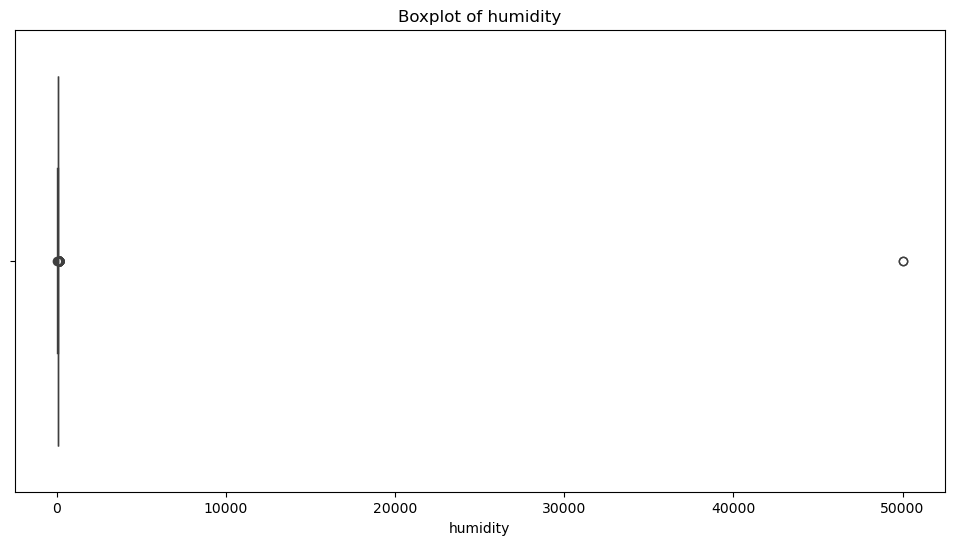

Outliers in 'humidity':
181        32.814149
4         118.713271
1322      118.713271
1319      118.713271
1286      118.713271
            ...     
490       118.713271
681       118.713271
1902      118.713271
1509    50000.000000
1022    50000.000000
Name: humidity, Length: 94, dtype: float64
number of outliers detected:6


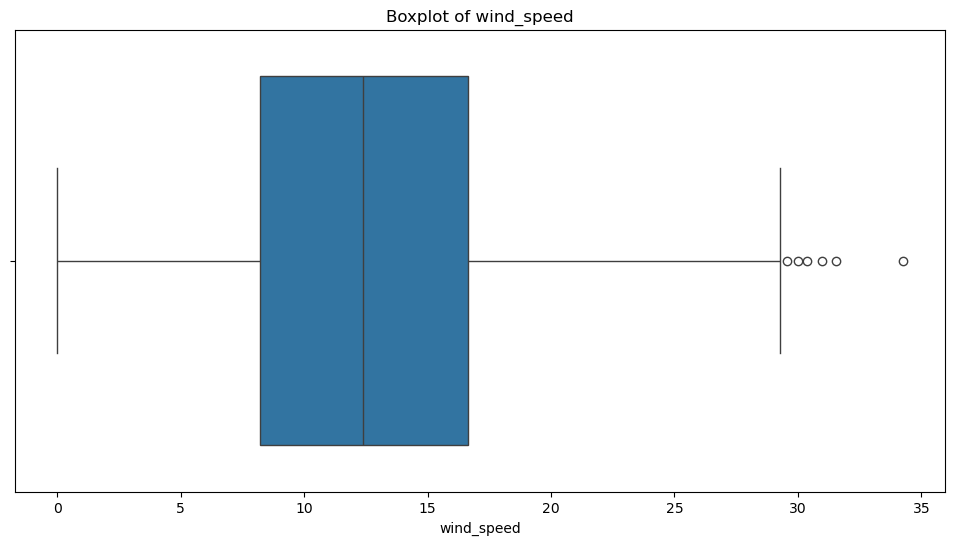

Outliers in 'wind_speed':
1157    29.556
1883    30.020
1159    30.384
1908    30.990
1884    31.536
1882    34.240
Name: wind_speed, dtype: float64
number of outliers detected:2


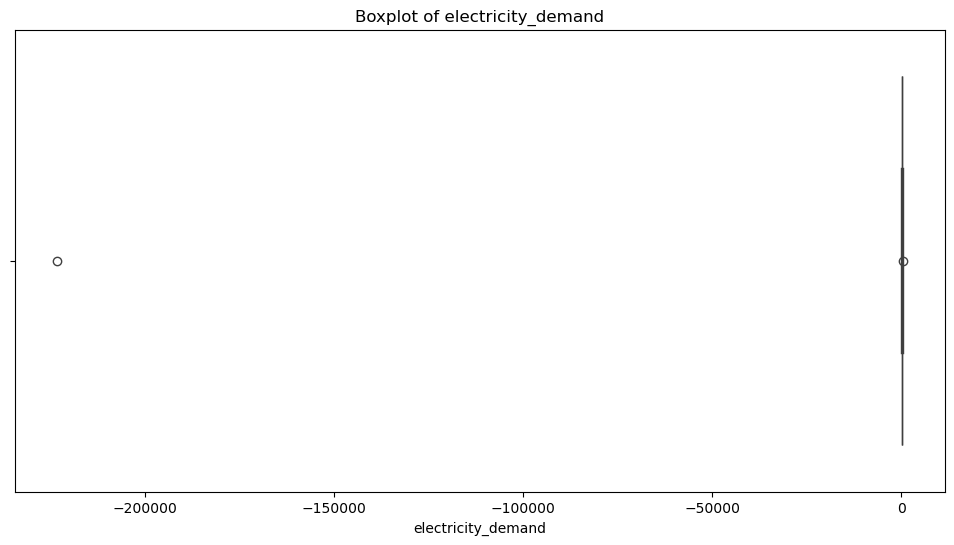

Outliers in 'electricity_demand':
1029   -223288.771683
416        387.741952
Name: electricity_demand, dtype: float64


In [388]:
def find_outliers_iqr(data, threshold=1.5):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    res = np.where((data < lower_bound) | (data > upper_bound))[0]
    print(f"number of outliers detected:{len(res)}")
    return res
cols = ['humidity', 'wind_speed', 'electricity_demand']
for col in cols:
    # Identify outliers in 'Marketing Budget'
    outlier_indices = find_outliers_iqr(df_train[col])
    outlier_mask = df_train.index.isin(outlier_indices)

    
    # Visualization of 'Marketing Budget' and 'Social Media Followers'
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=col, data=df_train)
    plt.title(f'Boxplot of {col}')
    plt.show()

    outliers = df_train.iloc[outlier_indices]
    print(f"Outliers in '{col}':")
    print(outliers[col].sort_values())
    

In [390]:
# Enlever les lignes des outliers
print("Before removing outliers:")
print(df_train.shape)
df_train.drop([1022,1509,1029],inplace = True)
print("Before removing outliers:")
print(df_train.shape)

Before removing outliers:
(1819, 19)
Before removing outliers:
(1816, 19)


# Validation croise pour calculer MAE

In [392]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

df_train_cleaned = df_train.drop(columns=['date'])

X_val = df_train_cleaned.drop(columns=['electricity_demand']) 
y_val = df_train_cleaned['electricity_demand'] 

model = LinearRegression()

tscv = TimeSeriesSplit(n_splits=5)  

mae_scores = cross_val_score(model, X_val, y_val, cv=tscv, scoring='neg_mean_absolute_error')

mae_scores = -mae_scores

print(f"MAE for each fold: {mae_scores}")
print(f"Average MAE: {np.mean(mae_scores)}")

MAE for each fold: [29.78205609 28.56339729 27.71073746 25.48785928 24.95054931]
Average MAE: 27.298919884205553


# Entrainer le modele sur tout le dataset

In [394]:
df_train = df_train.drop(columns=['date'],inplace = True)
X = df_train_cleaned.drop(columns=['electricity_demand'])
y = df_train_cleaned['electricity_demand']
model_lin = LinearRegression()
model_lin.fit(X, y)

LinearRegression()

# Preprosessing pour X test

In [396]:
X_test =  pd.read_csv("module5_exercise_test.csv", sep=",")
# Generating Submission File
submission = pd.DataFrame({
    'date': X_test['date']
})
# km/h pour toutes les lignes
X_test['wind_speed_value'] = X_test['wind_speed'].str.extract(r'(\d+\.?\d*)').astype(float)
X_test['wind_speed_unit'] = X_test['wind_speed'].str.extract(r'([a-zA-Z/]+)')

# 1 m/s = 3.6km/h
X_test.loc[X_test['wind_speed_unit'] == 'm/s', 'wind_speed_value'] *= 3.6

X_test['wind_speed'] = X_test['wind_speed_value']

X_test = X_test.drop(columns=['wind_speed_value', 'wind_speed_unit'])

X_test.drop('date',inplace=True,axis=1)

X_test = pd.get_dummies(X_test, columns=['weather_condition'])

X_test['oil_price_label'] = X_test['oil_brent_price_indicator'].map(price_mapping)
X_test.drop('oil_brent_price_indicator',axis=1,inplace=True)

In [398]:
numeric_cols = X_test.select_dtypes(include=['number']).columns

imputer = SimpleImputer(strategy='mean')

X_test[numeric_cols] = imputer.fit_transform(X_test[numeric_cols])

X_test.isnull().sum()

humidity                    0
wind_speed                  0
temperature_station1        0
temperature_station2        0
temperature_station3        0
temperature_station4        0
temperature_station5        0
temperature_station6        0
temperature_station7        0
temperature_station8        0
temperature_station9        0
temperature_station10       0
weather_condition_Cloudy    0
weather_condition_Rainy     0
weather_condition_Snowy     0
weather_condition_Sunny     0
oil_price_label             0
dtype: int64

# Prediction sur Xtest

In [400]:
y_test_pred = model_lin.predict(X_test)
submission['electricity_demand'] = y_test_pred

# Save the submission file
submission.to_csv('submission.csv', index=False, sep=',')
print("Submission file saved as 'submission.csv'.")

Submission file saved as 'submission.csv'.
